In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

In [3]:
import psycopg2


postgresDb = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

In [4]:
class Stockdatadao:
    def __init__(self, db):
        self.db = db

    def select(self, symbol):
        cursor = self.db.cursor()
        sql = """SELECT date_time, open, high, low, close, volume, adj_close
                    FROM stock_data WHERE symbol = %s"""
        val = (symbol,)

        cursor.execute(sql, val)
        result = cursor.fetchall()
        list_stock_data = []

        for item in result:
            list_stock_data.append(
                StockDataViewModel(date_time=item[0], open=item[1], high=item[2], low=item[3],
                                   close=item[4], volume=item[5], adj_close=item[6]))

        cursor.close()
        if result is None:
            return None
        else:
            return list_stock_data


class StockDataViewModel:
    def __init__(self, date_time, open, high, low, close, volume, adj_close):
        self.date_time = date_time
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.adj_close = adj_close

    def to_dict(self):
        return {
            'date_time': self.date_time,
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'adj_close': self.adj_close
        }

In [5]:
stock_data_dao = Stockdatadao(postgresDb)

stock_data = stock_data_dao.select('AAPL')

df = pd.DataFrame([s.to_dict() for s in stock_data], columns=['date_time', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])

df = df.rename(columns={'date_time': 'date'})

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['volume'] = df['volume'].astype(float)
print(df.head(10))

                open      high       low     close       volume  adj_close
date                                                                      
1980-12-12  0.128348  0.128906  0.128348  0.128348  469033600.0   0.099584
1980-12-15  0.122210  0.122210  0.121652  0.121652  175884800.0   0.094388
1980-12-16  0.113281  0.113281  0.112723  0.112723  105728000.0   0.087461
1980-12-17  0.115513  0.116071  0.115513  0.115513   86441600.0   0.089625
1980-12-18  0.118862  0.119420  0.118862  0.118862   73449600.0   0.092224
1980-12-19  0.126116  0.126674  0.126116  0.126116   48630400.0   0.097852
1980-12-22  0.132254  0.132813  0.132254  0.132254   37363200.0   0.102614
1980-12-23  0.137835  0.138393  0.137835  0.137835   46950400.0   0.106945
1980-12-24  0.145089  0.145647  0.145089  0.145089   48003200.0   0.112573
1980-12-26  0.158482  0.159040  0.158482  0.158482   55574400.0   0.122964


In [6]:
###get the dataset of AAPL stock from 2013-01-01 to 2023-06-01 from df
df = df.loc['2013-01-01':'2023-06-29']

print(df.last('3D'))

                  open        high         low       close      volume  \
date                                                                     
2023-06-27  185.889999  188.389999  185.669998  188.059998  50730800.0   
2023-06-28  187.929993  189.899994  187.600006  189.250000  51216800.0   
2023-06-29  189.080002  190.070007  188.940002  189.589996  46126000.0   

             adj_close  
date                    
2023-06-27  188.059998  
2023-06-28  189.250000  
2023-06-29  189.589996  


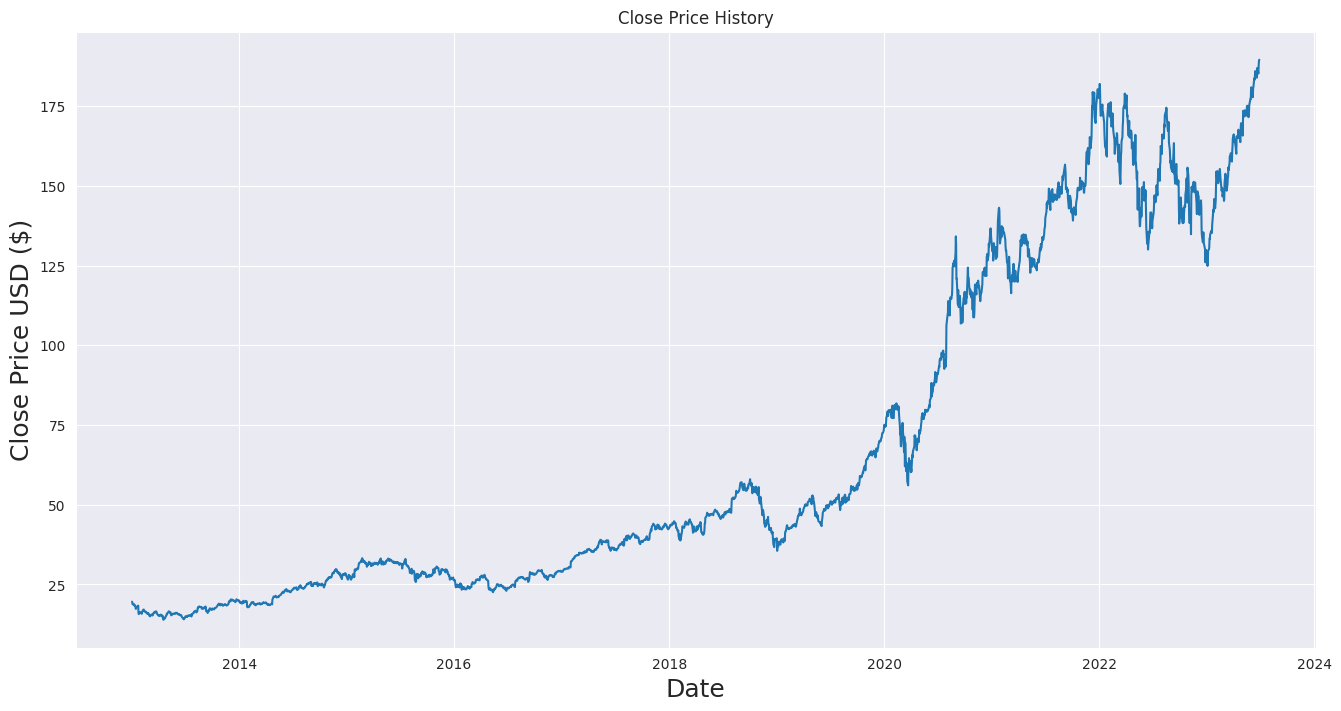

In [7]:
###plot the close price history of AAPL stock from 2013-01-01 to 2023-06-01 from df using matplotlib

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [8]:
#adding a field to the data set for calculating the mean of high and low price in df

df['Mean'] = (df['high'] + df['low']) / 2.0

df.head(2)

,open,high,low,close,volume,adj_close,Mean
date,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2013-01-02 to 2023-06-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2641 non-null   float64
 1   high       2641 non-null   float64
 2   low        2641 non-null   float64
 3   close      2641 non-null   float64
 4   volume     2641 non-null   float64
 5   adj_close  2641 non-null   float64
 6   Mean       2641 non-null   float64
dtypes: float64(7)
memory usage: 165.1 KB


In [10]:
#We need to restructure the data set by adding a target column ‘Actual’, which will the stock prices for the next day.

steps=-1
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,open,high,low,close,volume,adj_close,Mean,Actual
date,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679,19.476250
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250,19.008214
2013-01-04,19.177500,19.236786,18.779642,18.821428,594333600.0,16.139196,19.008214,18.651785


In [11]:
##dropping columns with null values in dataset_for_prediction

dataset_for_prediction = dataset_for_prediction.dropna()

Text(0.5, 1.0, ' Apple Stock Value')

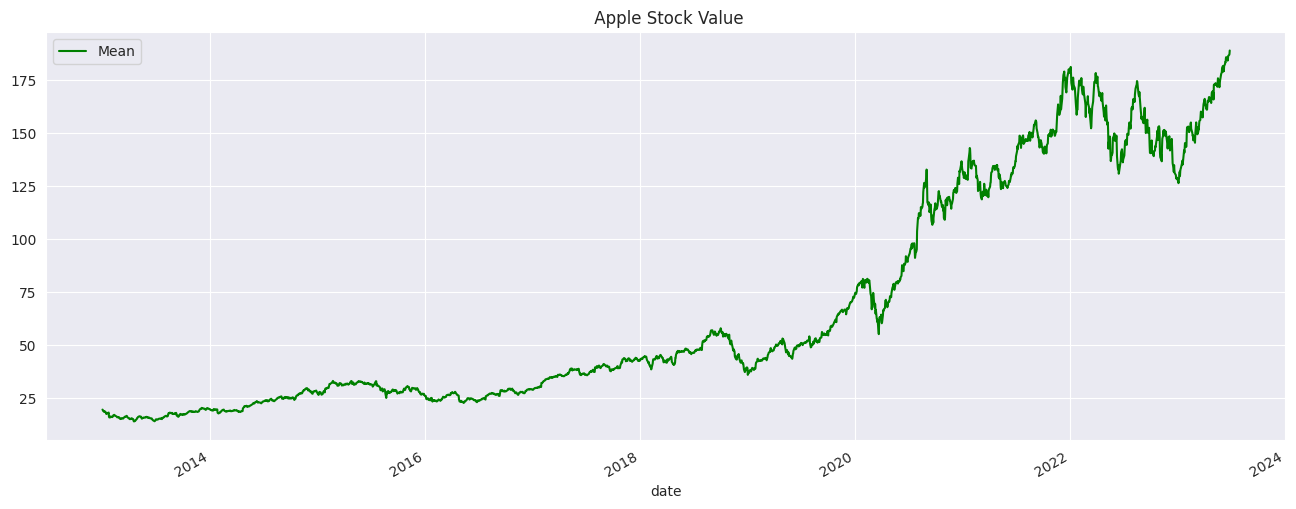

In [13]:
#plot the mean stock prices for the current dataset and lock the trends from df

dataset_for_prediction['Mean'].plot(color='green', figsize=(16, 6))
plt.legend(['Mean'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple Stock Volume')

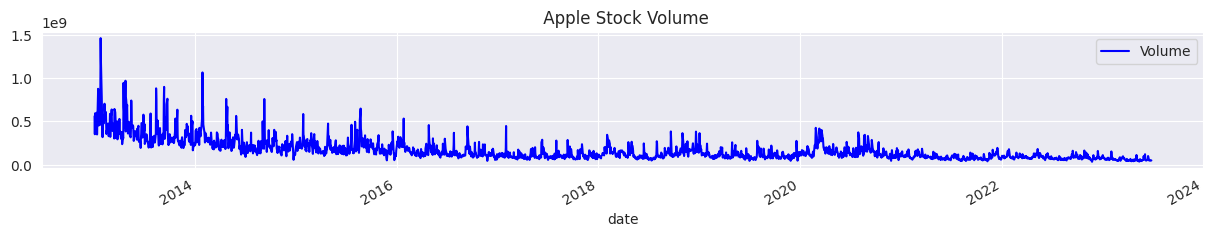

In [14]:
#Plotting volume of Apple stocks sold daily from df

dataset_for_prediction['volume'].plot(color='blue', figsize=(15, 2))
plt.legend(['Volume'])
plt.title(" Apple Stock Volume")

In [61]:
#Normalizing the input and target features
#Since the stock prices and volume are on a different scale, we need to normalize the data. We use MinMaxScaler; it will scale the data to a fixed range between 0 to 1
# Scaling the input features- Low, High, Open, Close, Volume, Adjusted Close, and Mean

# from sklearn.preprocessing import MinMaxScaler
#
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_input = scaler.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean']])
# scaled_input = pd.DataFrame(scaled_input) df = df.loc['2013-01-01':'2023-06-29']

X = dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean']].loc['2013-01-01':'2022-12-31']
X.last('3D')

,low,high,open,close,volume,adj_close,Mean
date,,,,,,,
2022-12-28,125.870003,131.029999,129.669998,126.040001,85438400.0,125.674026,128.450001
2022-12-29,127.730003,130.479996,127.989998,129.610001,75703700.0,129.233658,129.105000
2022-12-30,127.430000,129.949997,128.410004,129.929993,77034200.0,129.552719,128.689999


In [62]:
#Get the dataset for validation from df

df_for_validation = dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean']].loc['2023-01-01':'2023-06-30']
df_for_validation.head(3)

,low,high,open,close,volume,adj_close,Mean
date,,,,,,,
2023-01-03,124.169998,130.899994,130.279999,125.070000,112117500.0,124.706833,127.534996
2023-01-04,125.080002,128.660004,126.889999,126.360001,89113600.0,125.993095,126.870003
2023-01-05,124.760002,127.769997,127.129997,125.019997,80962700.0,124.656975,126.264999


In [63]:
y = dataset_for_prediction[['Actual']].loc['2013-01-01':'2022-12-31']
y.last('3D')

,Actual
date,
2022-12-28,129.105000
2022-12-29,128.689999
2022-12-30,127.534996


In [64]:
df_for_validation_actual = dataset_for_prediction[['Actual']].loc['2023-01-01':'2023-06-30']
df_for_validation_actual.head(2)

,Actual
date,
2023-01-03,126.870003
2023-01-04,126.264999


In [66]:
#renaming the target variable

y.rename(columns={"Actual": 'Stock Price Next Day'}, inplace=True)
y.last('3D')

,Stock Price Next Day
date,
2022-12-28,129.105000
2022-12-29,128.689999
2022-12-30,127.534996


In [67]:
#Splitting the dataset into training and testing sets

temp_df = df.loc['2013-01-01':'2022-12-31']

train_size = int(len(temp_df) * 0.80)
test_size = int(len(temp_df) - train_size)
print(test_size)

504


In [68]:
#Splitting the dataset into training and testing sets using train_size and test_size from df and y respectively
train_X, train_Y = X[:train_size].dropna(), y[:train_size].dropna()
print(X)
print(y)

test_X, test_Y = X[train_size:].dropna(), y[train_size:].dropna()

                   low        high        open       close       volume  \
date                                                                      
2013-01-02   19.343929   19.821428   19.779285   19.608213  560518000.0   
2013-01-03   19.321428   19.631071   19.567142   19.360714  352965200.0   
2013-01-04   18.779642   19.236786   19.177500   18.821428  594333600.0   
2013-01-07   18.400000   18.903570   18.642857   18.710714  484156400.0   
2013-01-08   18.616072   18.996071   18.900356   18.761070  458707200.0   
...                ...         ...         ...         ...          ...   
2022-12-23  129.639999  132.419998  130.919998  131.860001   63814900.0   
2022-12-27  128.720001  131.410004  131.380005  130.029999   69007800.0   
2022-12-28  125.870003  131.029999  129.669998  126.040001   85438400.0   
2022-12-29  127.730003  130.479996  127.989998  129.610001   75703700.0   
2022-12-30  127.430000  129.949997  128.410004  129.929993   77034200.0   

             adj_close  

In [69]:
test_X.columns

Index(['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean'], dtype='object')

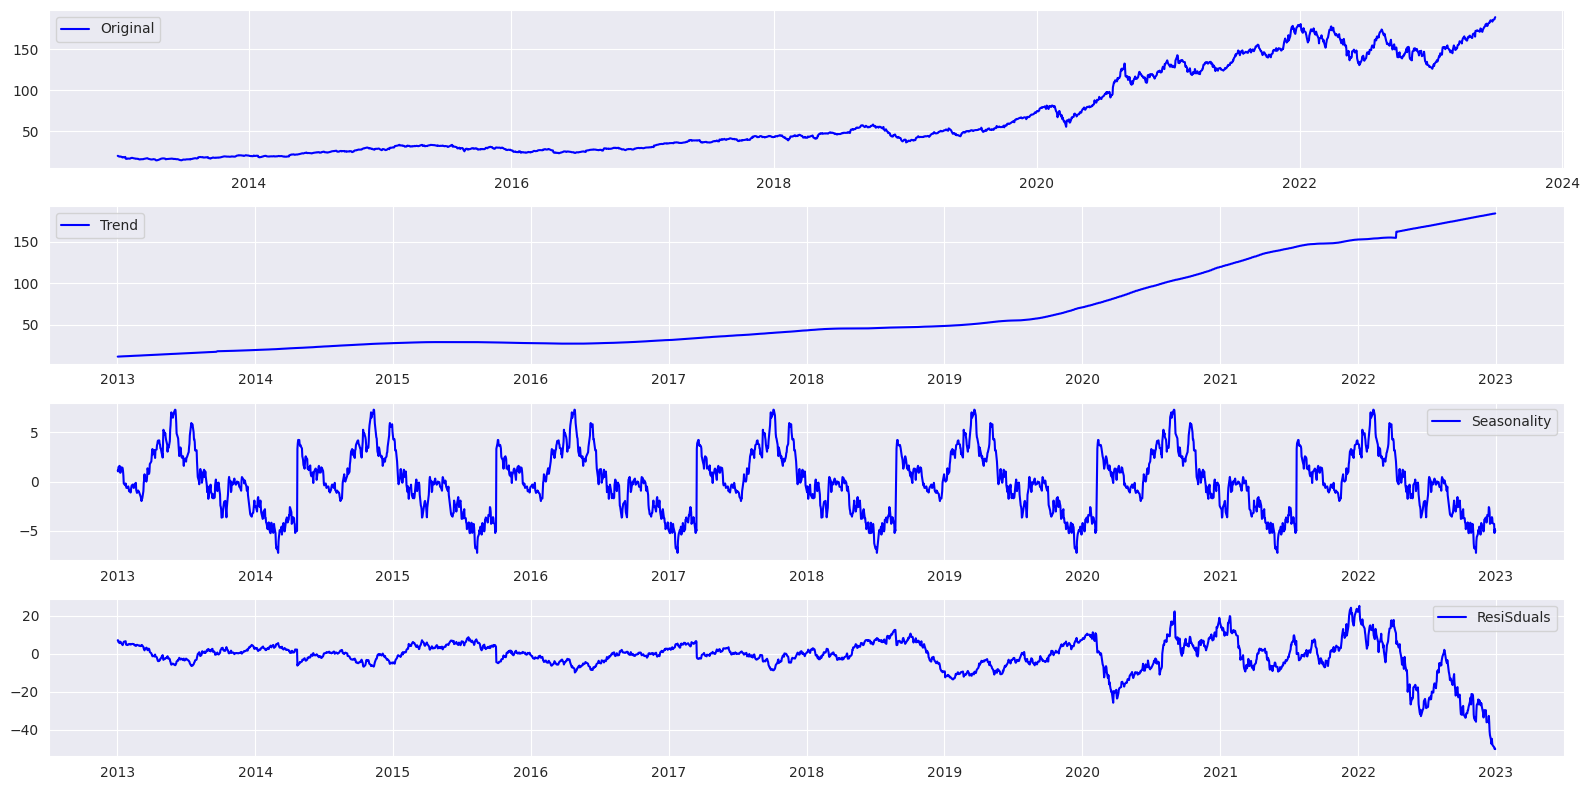

In [71]:
# ###Understanding the Time series data
# Decomposing Time Series into several components-Trend, Seasonality, and Random noise
#
# We know that Time series data is composed of Level, Trend, Seasonality, and Random noise. Let’s decompose the data and plot the trend, seasonality, and randomness in the data.
#
# We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.
#
# Additive model = Trend + Seasonality + Random Noise

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X['Mean'], model='add', period=365, extrapolate_trend='freq', two_sided=True, filt=None)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Mean'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='ResiSduals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [72]:
###Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)


In [76]:
#Checking for stationary in the data using the ADF test

y_test = y['Stock Price Next Day'][:train_size].dropna()
test_adf(y_test, 'Stock Price Next Day')

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price Next Day


In [77]:
#Make the data stationary by differencing the data

y_test_diff = y_test.diff().dropna()
test_adf(y_test_diff, 'Stock Price Next Day')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Stock Price Next Day


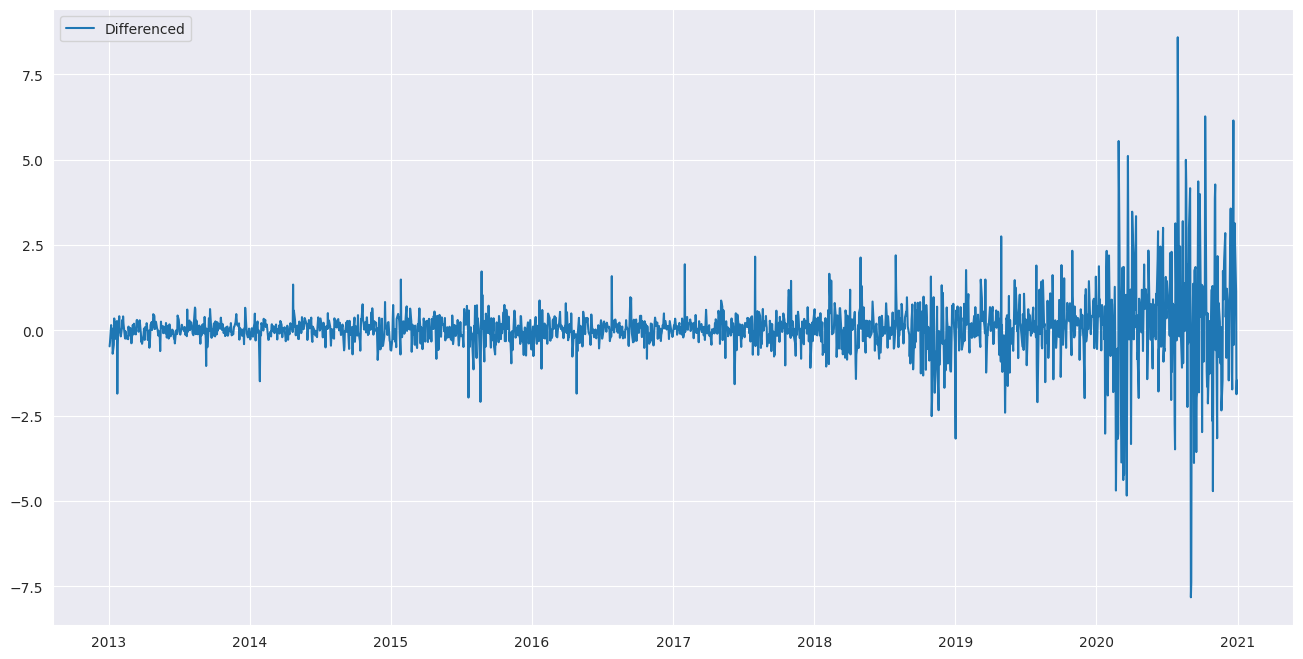

In [78]:
#Plotting the differenced data

plt.figure(figsize=(16, 8))
plt.plot(y_test_diff, label='Differenced')
plt.legend(loc='best')
plt.show()

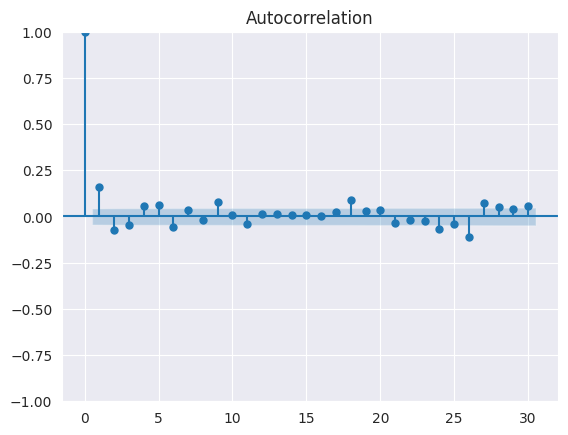

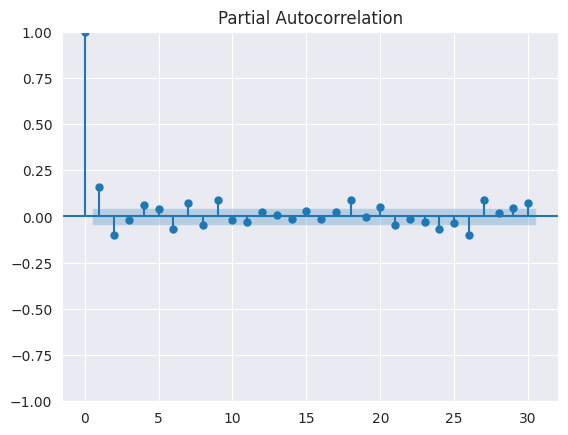

In [79]:
#Plotting the autocorrelation plot for the differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_test_diff, lags=30)
plot_pacf(y_test_diff, lags=30)
plt.show()

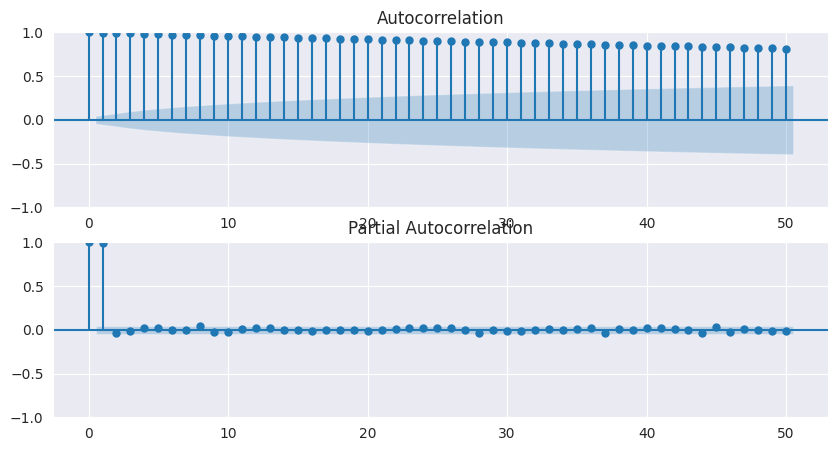

In [80]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [45]:
#Get the best parameters of seasonal orders for the SAIRMAX model using the auto_arima function from pmdarima library.

from pmdarima.arima import auto_arima

step_wise=auto_arima(train_Y, exogenous= train_X,
                       start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6419.899, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5904.218, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6358.280, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5566.612, Time=1.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5625.313, Time=0.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5547.563, Time=1.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5896.096, Time=0.58 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.52 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5545.647, Time=1.50 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5890.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2014
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2766.824
Date:                            Wed, 05 Jul 2023   AIC                           5545.647
Time:                                    20:50:13   BIC                           5579.256
Sample:                                         0   HQIC                          5557.987
                                           - 2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1864      0.008     23.080      0.000       0.171       0.202
ar.L2         -0.0953      0.012     -7.956      0.000      -0.119      -0.072
ar.L3         -0.0443      0.011     -3.945      0.000      -0.066      -0.022
ar.S.L12      -0.6358      0.009    -73.732      0.000      -0.653      -0.619
ar.S.L24      -0.4106      0.009    -44.256      0.000      -0.429      -0.392
sigma2         0.9268      0.010     91.299      0.000       0.907       0.947
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             31665.05
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              17.54   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

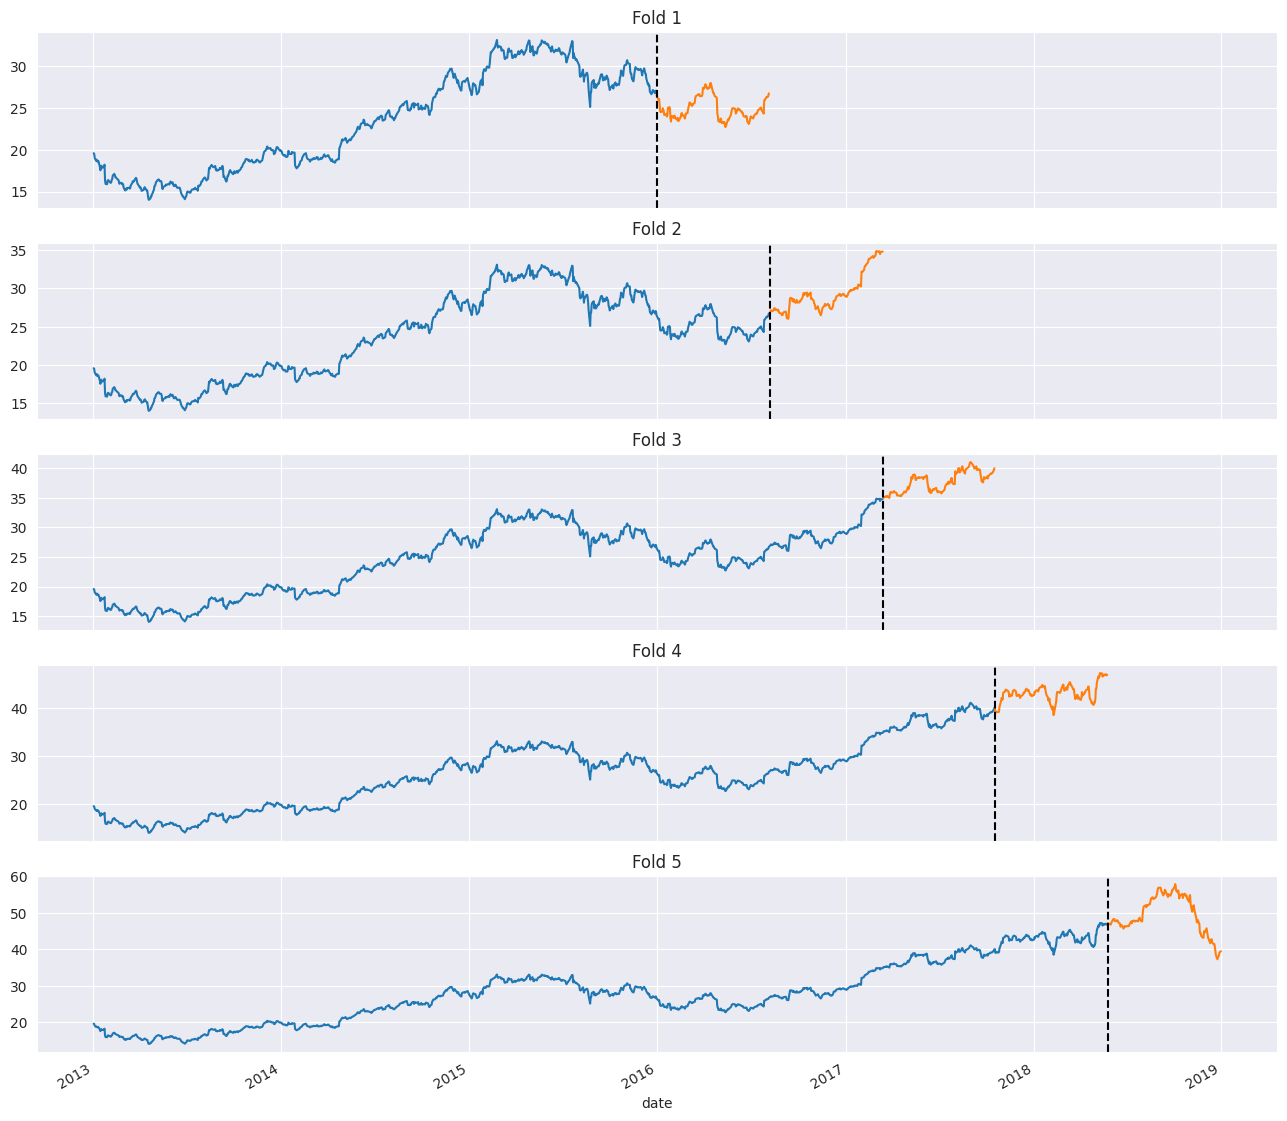

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.133851
         Iterations: 13
         Function evaluations: 1908


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


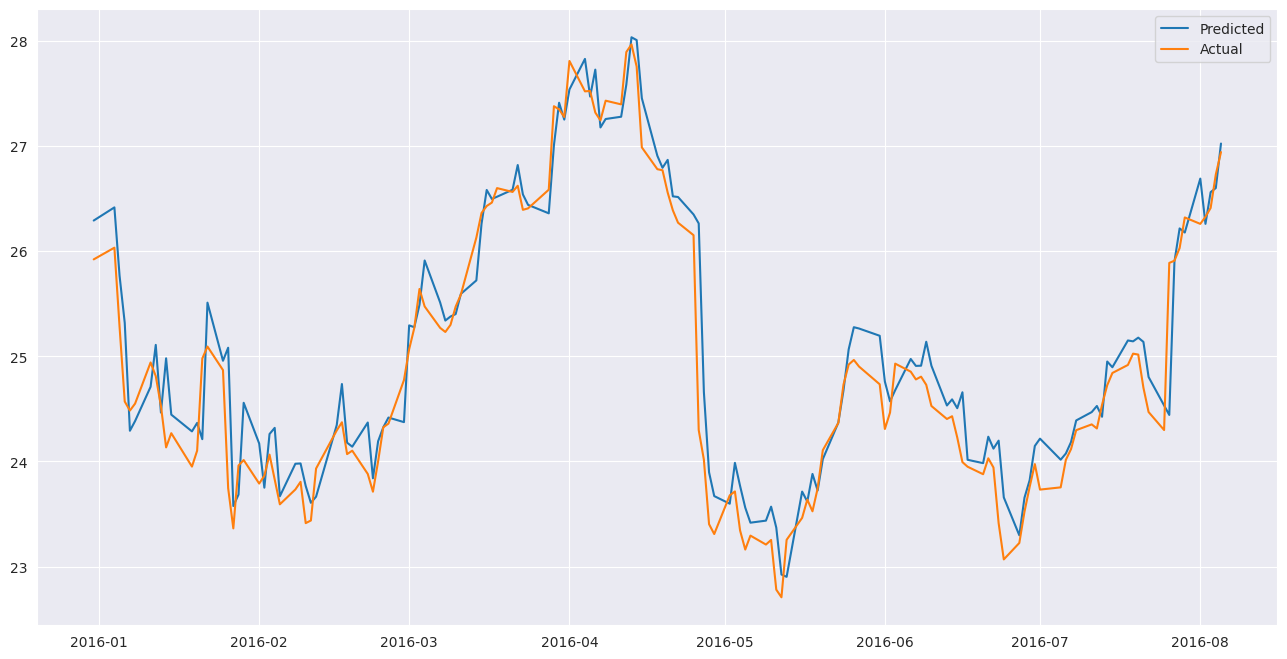

Mean Absolute Percentage Error:  0.0105204728648614


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.172231
         Iterations: 19
         Function evaluations: 2799


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


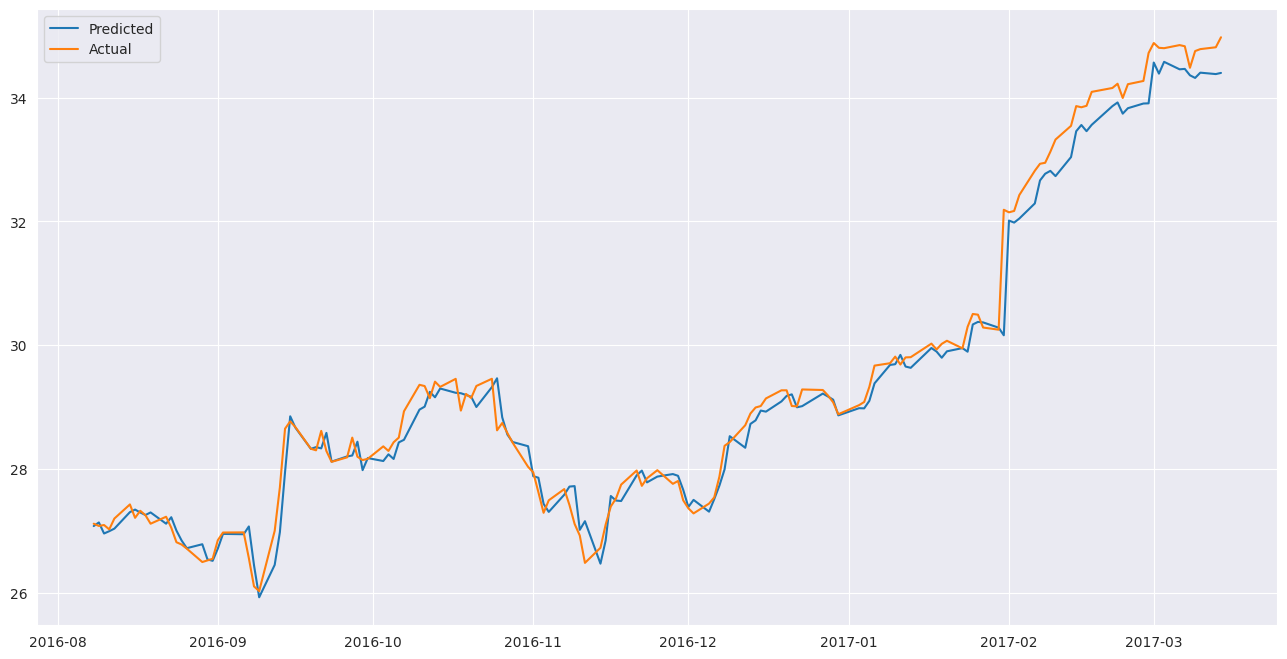

Mean Absolute Percentage Error:  0.007367425412309249


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.165052
         Iterations: 15
         Function evaluations: 2172


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


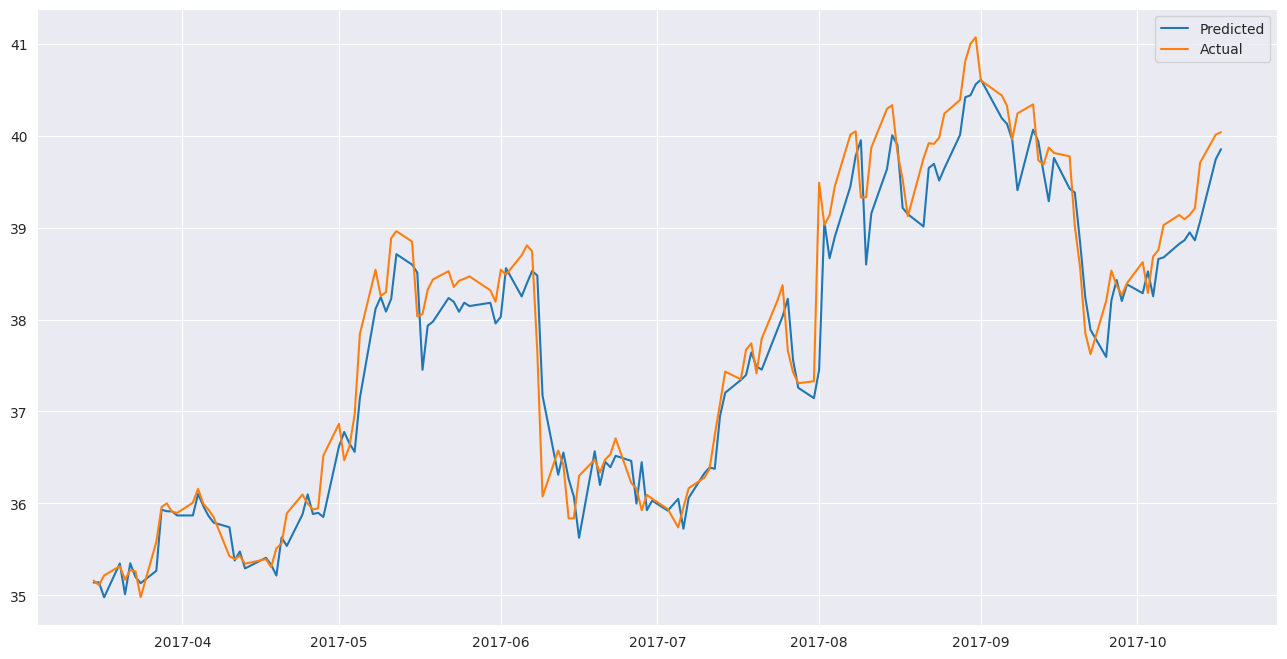

Mean Absolute Percentage Error:  0.007302582691028509


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.189821
         Iterations: 12
         Function evaluations: 1727


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


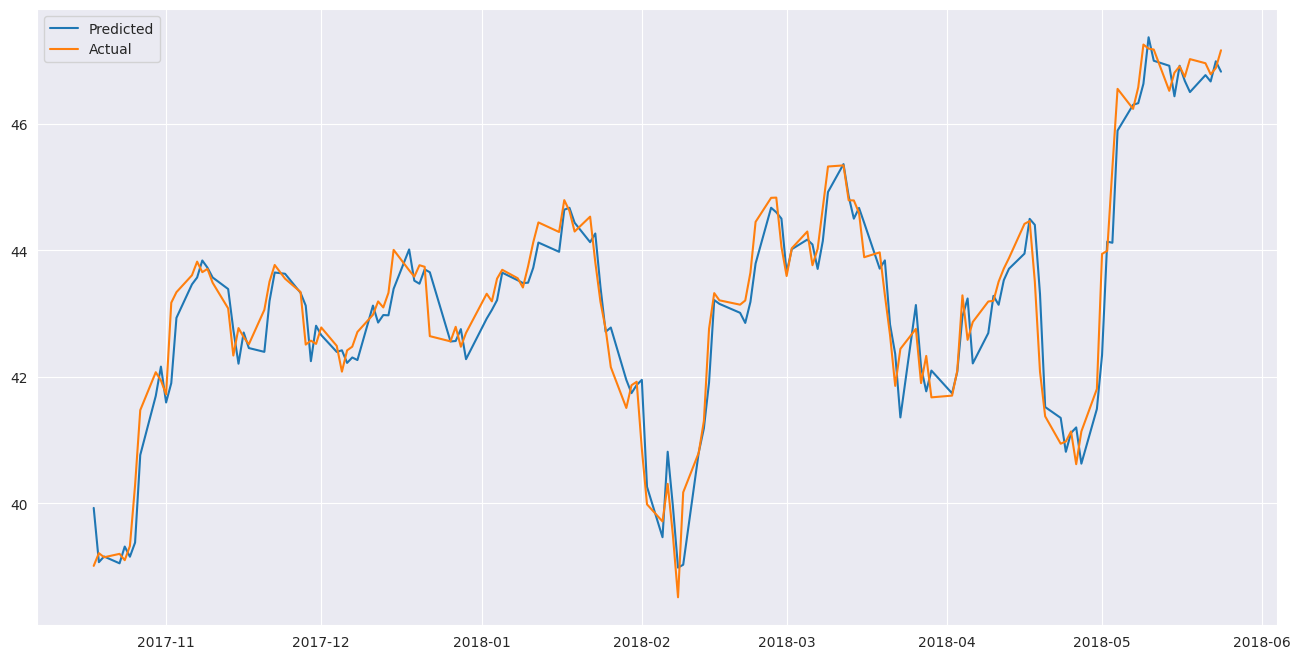

Mean Absolute Percentage Error:  0.00774781402871867


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.256427
         Iterations: 28
         Function evaluations: 4030


/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


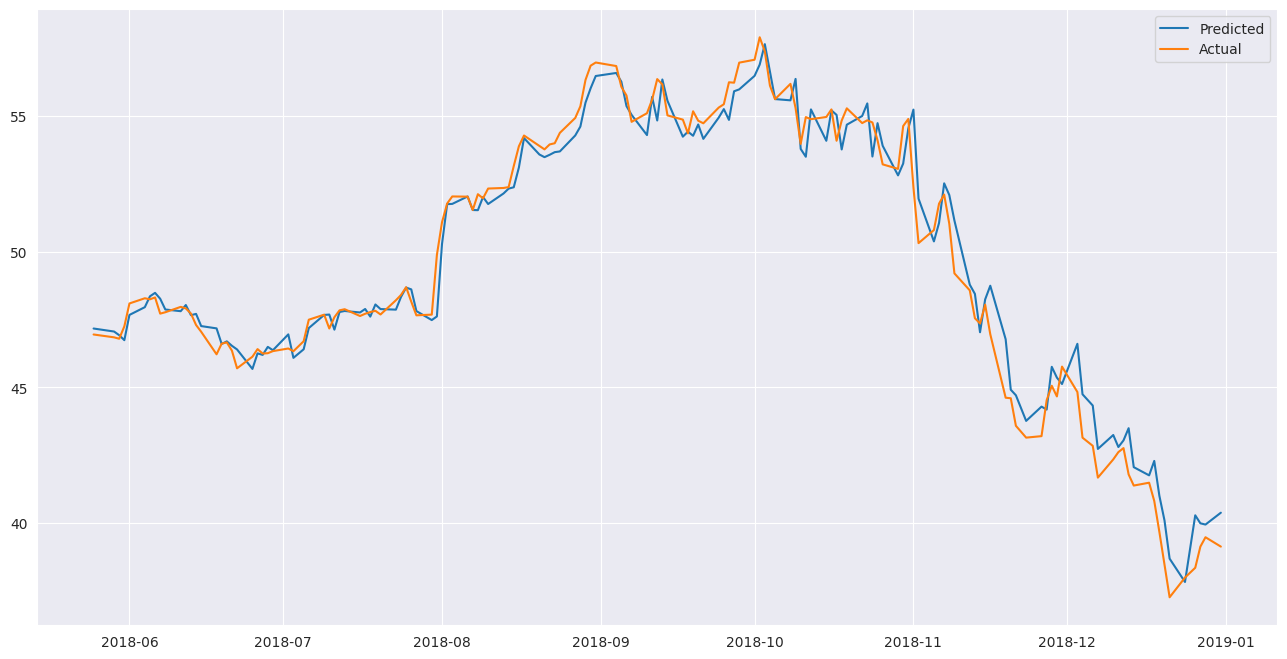

Mean Absolute Percentage Error:  0.01216804812935145


In [51]:
import warnings
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

total_samples = len(train_X)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)

# n_splits = total_samples - test_size

tscv = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)

train_X = train_X.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(5, 1 , figsize=(16, 15), sharex=True)
fold = 0

for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    X_train["Mean"].plot(ax=ax[fold], label='Training Set', title='Fold {}'.format(fold+1))
    X_test["Mean"].plot(ax=ax[fold], label='Test Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1
plt.show()

for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    model = SARIMAX(endog=y_train, exog=X_train, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)
    # model = SARIMAX(endog=y_train, exog=X_train, order=(2, 1, 0), seasonal_order=(2,1,0,12), enforce_invertibility=False, enforce_stationarity=False)

    model_fit = model.fit(maxiter=200, method='powell', disp=True, full_output=True)
    y_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)

    ##plot the predicted and actual values from y_pred and x_test
    y_pred.reset_index(drop=True, inplace=True)
    y_pred.index=X_test.index

    plt.figure(figsize=(16, 8))
    plt.plot(y_pred, label='Predicted')
    plt.plot(y_test, label='Actual')
    plt.legend(loc='best')
    plt.show()

    print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_test, y_pred))

In [95]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X, order=(0, 1, 3), seasonal_order=(1,1,2,12), enforce_invertibility=False, enforce_stationarity=False)

model_fit = model.fit(maxiter=200, method='powell', disp=True, full_output=True)
print(model_fit.summary())

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 1.117692
         Iterations: 12
         Function evaluations: 1749
                                        SARIMAX Results                                        
Dep. Variable:                    Stock Price Next Day   No. Observations:                 2014
Model:             SARIMAX(0, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -2251.031
Date:                                 Wed, 05 Jul 2023   AIC                           4530.063
Time:                                         21:43:11   BIC                           4608.285
Sample:                                              0   HQIC                          4558.804
                                                - 2014                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [87]:
#Predicting the values in the validation data using the SARIMAX model

forecast = model_fit.forecast(steps=len(df_for_validation), exog=df_for_validation)

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [92]:
#Plotting the forecasted values

forecast_apple= pd.DataFrame(forecast)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=df_for_validation_actual.index
forecast_apple["Actual"] =df_for_validation_actual
forecast_apple.rename(columns={0:"Forecast"}, inplace=True)

<Axes: xlabel='date'>

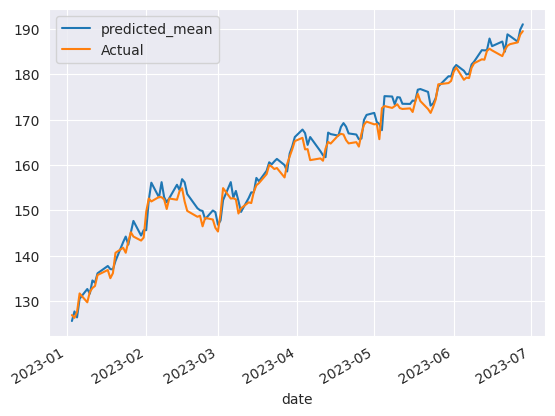

In [93]:
forecast_apple["predicted_mean"].plot(legend=True)
forecast_apple["Actual"].plot(legend=True)

In [94]:
from statsmodels.tools.eval_measures import rmse
error=rmse(forecast_apple["predicted_mean"], forecast_apple["Actual"])
error

1.9938657708974656